In [4]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
#import torch
#torch.manual_seed(SEED)
#from torch import nn
#from torchsummary import summary
#from torch.utils.tensorboard import SummaryWriter
#import torchvision
#from torchvision.transforms import v2 as transforms
#from torch.utils.data import TensorDataset, DataLoader
#!pip install torchview
#from torchview import draw_graph

# Configurazione di TensorBoard e directory
#logs_dir = "tensorboard"
#!pkill -f tensorboard
#%load_ext tensorboard
#!mkdir -p models

#if torch.cuda.is_available():
 #   device = torch.device("cuda")
  #  torch.cuda.manual_seed_all(SEED)
   # torch.backends.cudnn.benchmark = True
#else:
#    device = torch.device("cpu")

#print(f"PyTorch version: {torch.__version__}")
#print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
#import requests
from io import BytesIO

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

In [11]:
import os
import cv2
import numpy as np
import pandas as pd

def load_images_from_folder(folder, labels_path=None):
    """
    Load and preprocess images from a specified folder in ALPHABETICAL order.
    """
    images = []
    labels = []
    
    # Mappatura delle etichette
    label_mapping = {
        'Luminal A': 0,
        'Luminal B': 1,
        'HER2(+)': 2,
        'Triple negative': 3
    }

    # 1. Preparazione Labels (Ottimizzazione)
    # Creiamo un dizionario per cercare le label in O(1) invece di scansionare il DF ogni volta
    label_dict = {}
    if labels_path is not None:
        df_labels = pd.read_csv(labels_path)
        # Assumiamo che 'sample_index' sia il nome del file
        label_dict = dict(zip(df_labels['sample_index'], df_labels['label']))

    # 2. Ottenere e ORDINARE la lista dei file
    # Questo è il passaggio cruciale per allineare Immagini e Maschere
    filenames = sorted(os.listdir(folder))

    for filename in filenames:
        # Costruiamo il path completo
        file_path = os.path.join(folder, filename)
        
        # Saltiamo file nascosti o non immagini se necessario
        if filename.startswith('.'): 
            continue

        img = cv2.imread(file_path)

        # Controllo se l'immagine è stata caricata (evita crash su file corrotti)
        if img is None:
            print(f"Warning: Impossibile caricare {filename}")
            continue

        # Normalizzazione [0, 1]
        img = (img / 255).astype(np.float32)

        # BGR to RGB
        img = img[..., ::-1]
        
        # Resize
        img = cv2.resize(img, (1024, 1024))
        
        # Gestione Label
        if labels_path is not None:
            # Recupera la label dal dizionario creato prima
            label_str = label_dict.get(filename)
            
            if label_str in label_mapping:
                labels.append(label_mapping[label_str])
            else:
                print(f"Label non trovata o non valida per: {filename}")
                # Decidi se saltare l'immagine o aggiungere una label placeholder
                # continue 
        
        images.append(img)

    # Restituisce array vuoto per le labels se non c'è il path
    labels_np = np.array(labels) if labels_path is not None else np.array([])
    
    return np.array(images), labels_np

# --- ESEMPIO DI UTILIZZO ---

images_path = '../data/processed/images/'
mask_path = '../data/processed/masks/'
labels_path = '../data/processed/train_labels_processed.csv'

print("Caricamento Immagini...")
images, labels = load_images_from_folder(images_path, labels_path=labels_path)

print("Caricamento Maschere...")
# Nota: qui ignoriamo il secondo valore di ritorno (le labels vuote)
masks, _ = load_images_from_folder(mask_path)

print("-" * 30)
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Masks shape: {masks.shape}")

# VERIFICA FINALE
# Se le cartelle contengono gli stessi nomi di file, ora gli indici corrispondono.
# images[0] corrisponderà a masks[0]
if images.shape[0] == masks.shape[0]:
    print("Successo: Numero di immagini e maschere corrispondente.")
else:
    print("Errore: Il numero di immagini e maschere non coincide!")

Caricamento Immagini...
Caricamento Maschere...
------------------------------
Images shape: (1261, 1024, 1024, 3)
Labels shape: (1261,)
Masks shape: (1261, 1024, 1024, 3)
Successo: Numero di immagini e maschere corrispondente.


Prime 10 labels: [3 0 0 1 2 1 1 0 3 1]


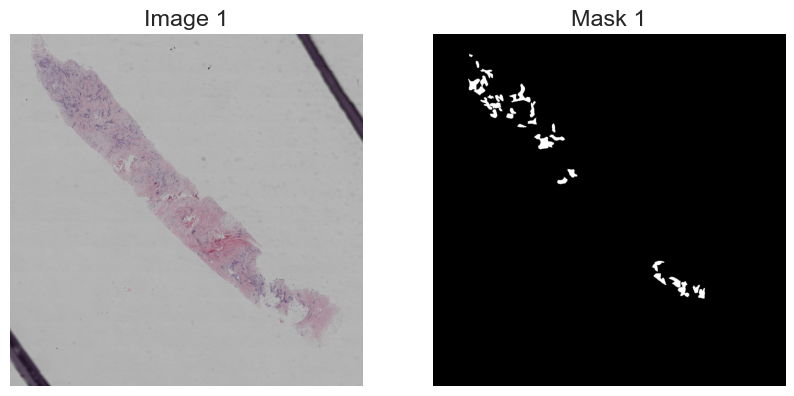

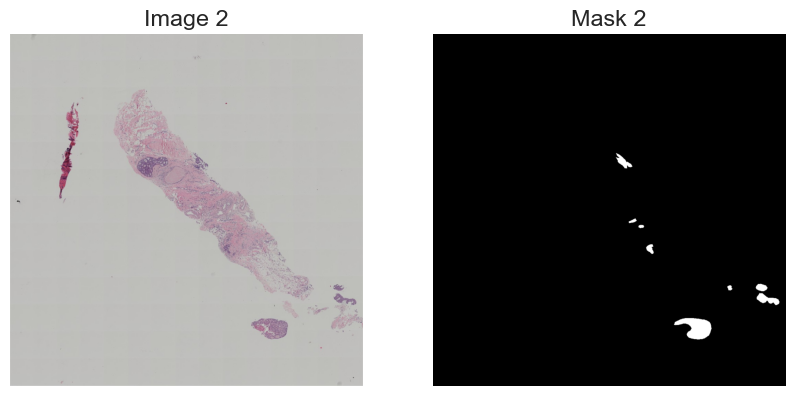

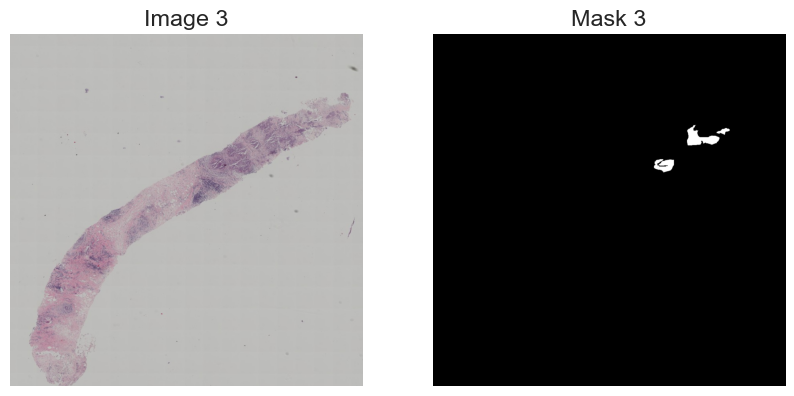

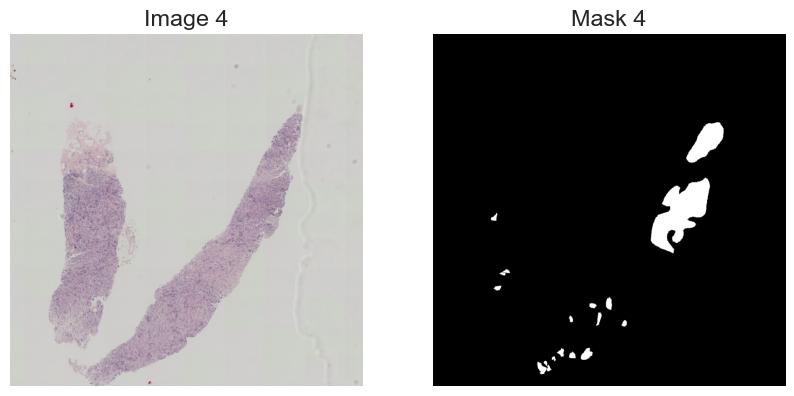

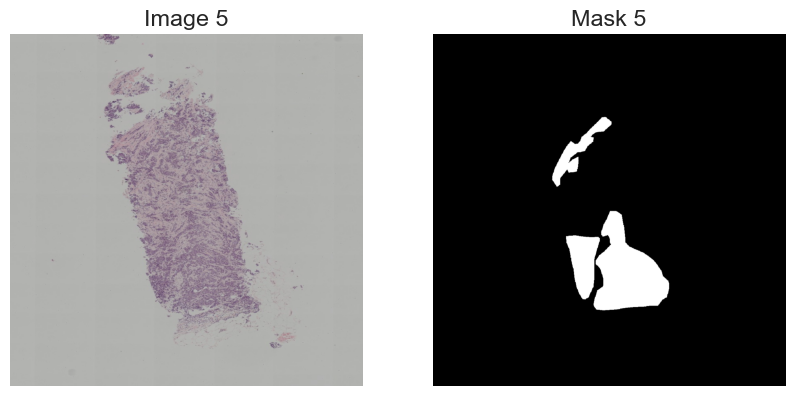

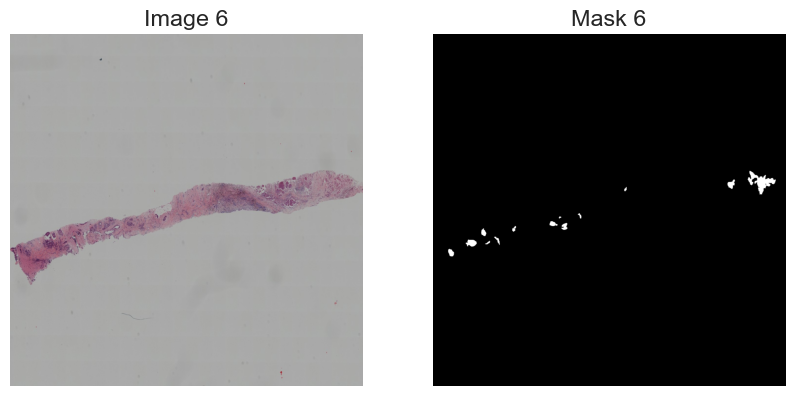

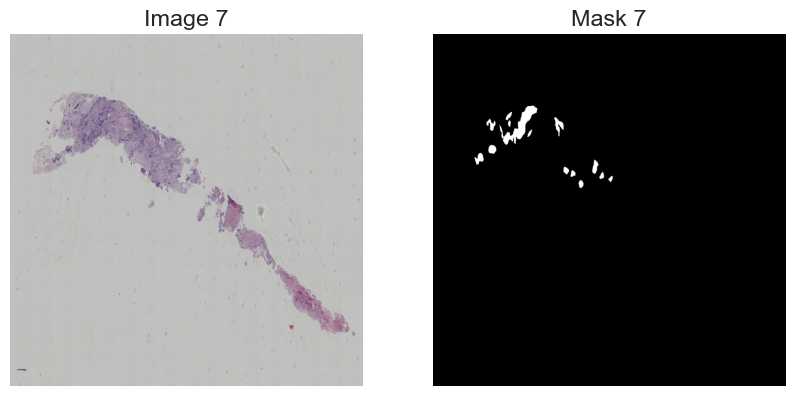

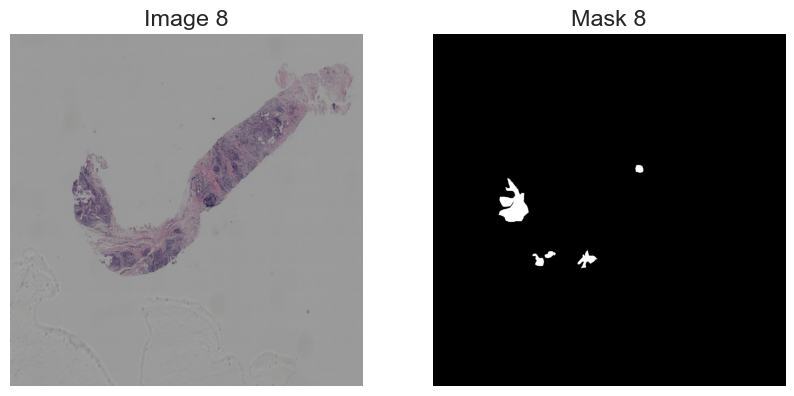

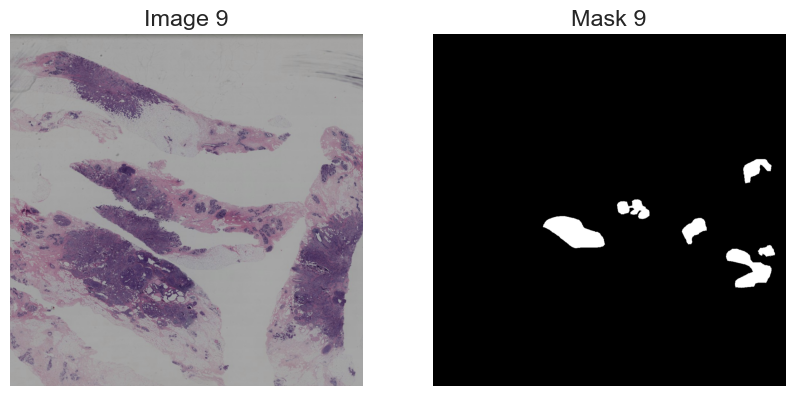

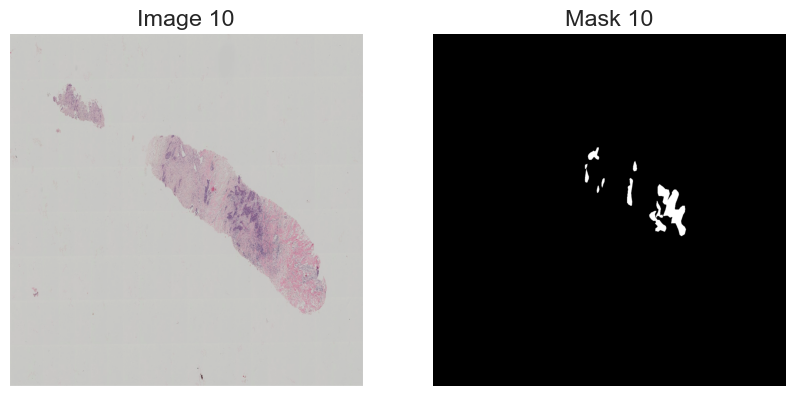

In [12]:
#stampa le prime 10 labels e le prime 5 foto e le prime 5 maschere per foto e maschere voglio visualizzarle proprio
print("Prime 10 labels:", labels[:10])
for i in range(10):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title(f"Image {i+1}")
    plt.imshow(images[i])
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title(f"Mask {i+1}")
    plt.imshow(masks[i], cmap='gray')
    plt.axis('off')
    
    plt.show()

In [9]:
def load_images_from_folder(folder, labels_path=None):
    """
    Load and preprocess images from a specified folder.

    Args:
        folder (str): Path to the folder containing images
        labels_path (str, optional): Path to the CSV file containing labels. Defaults to None.

    Returns:
        np.ndarray: Array of preprocessed images with shape (N, H, W, C)
    """
    images = []
    labels = []
    if labels_path is not None:
            df_labels = pd.read_csv(labels_path)
    # Iterate through files in the specified folder
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[...,::-1]
        
        # Resize the image to 1024x1024 pixels
        img = cv2.resize(img, (1024, 1024))
        
        label = df_labels[df_labels['sample_index'] == filename]['label'].values[0] if labels_path is not None else None
        print(f"Filename: {filename}, Label: {label}")
        label_mapping = {
            'Luminal A': 0,
            'Luminal B': 1,
            'HER2(+)': 2,
            'Triple negative': 3
        }
        labels.append(label_mapping[label]) if label is not None else None
        if img is not None:
            images.append(img)

    return np.array(images), np.array(labels)

# Load images from the 'animals/' folder
images_path = '../data/processed/images/'
mask_path = '../data/processed/masks/'
labels_path = '../data/processed/train_labels_processed.csv'
images, labels = load_images_from_folder(images_path, labels_path=labels_path)
mask, _ = load_images_from_folder(mask_path)

#print the shape of images and labels
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Masks shape: {mask.shape}")

Filename: img_0564.png, Label: Luminal B
Filename: img_0202.png, Label: Luminal B
Filename: img_0216.png, Label: Luminal B
Filename: img_1108.png, Label: Triple negative
Filename: img_0570.png, Label: Luminal B
Filename: img_0558.png, Label: HER2(+)
Filename: img_1120.png, Label: HER2(+)
Filename: img_1134.png, Label: Luminal A
Filename: img_0000.png, Label: Triple negative
Filename: img_0766.png, Label: HER2(+)
Filename: img_0772.png, Label: Luminal B
Filename: img_0014.png, Label: Luminal A
Filename: img_1322.png, Label: Luminal A
Filename: img_0982.png, Label: HER2(+)
Filename: img_0996.png, Label: Luminal B
Filename: img_1336.png, Label: HER2(+)
Filename: img_0028.png, Label: HER2(+)
Filename: img_0969.png, Label: Luminal A
Filename: img_0941.png, Label: Luminal A
Filename: img_0799.png, Label: Luminal B
Filename: img_0955.png, Label: Triple negative
Filename: img_0174.png, Label: Luminal A
Filename: img_0612.png, Label: Luminal A
Filename: img_0160.png, Label: Triple negative
File

Labels: [1 1 1 ... 1 2 0]
